In [1]:
import os

os.chdir(r'c:\Users\Gur Levy\Desktop\PORTFOLIO\DE_PORTFOLIO')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


In [5]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

data = pd.read_csv('combined_data.csv')
data = data[data['Player'] == 'E. Haaland']
# mean as a measure for binary
actions = np.mean(data['Successful actions'])
shots = np.mean(data['Shots on target'])
dribbles = np.mean(data['Successful dribbles'])
off_duels = np.mean(data['Offensive duels won'])
touches_in_penalty_area = np.mean(data['Touches in penalty area'])

# turn to binary
data['Goal_Scored'] = data['Goals'].apply(lambda x: 1 if x > 0 else 0)
data['actions_binary'] = data['Successful actions'].apply(lambda x: 1 if x >= actions else 0)
data['shots_binary'] = data['Shots on target'].apply(lambda x: 1 if x >= shots else 0)
data['dribbles_binary'] = data['Successful dribbles'].apply(lambda x: 1 if x >= dribbles else 0)
data['off_duels_binary'] = data['Offensive duels won'].apply(lambda x: 1 if x >= off_duels else 0)
data['touches_in_penalty_area_binary'] = data['Touches in penalty area'].apply(lambda x: 1 if x >= touches_in_penalty_area else 0)

Y = data['Goal_Scored']
X = data[['actions_binary', 'shots_binary', 'dribbles_binary', 'off_duels_binary', 'touches_in_penalty_area_binary']]



In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)
# VIF > 1 and < 5: Moderate multicollinearity. The variance of the regression coefficient is moderately inflated.

                          Feature       VIF
0                  actions_binary  2.846876
1                    shots_binary  2.153611
2                 dribbles_binary  2.230565
3                off_duels_binary  3.293567
4  touches_in_penalty_area_binary  2.016648


In [7]:
YX = np.hstack((np.array(Y)[:, np.newaxis], X))
YX = YX[~np.any(np.isnan(YX), axis=1)]
# Examine the correlation between covariates (IV) and outcome (outcome is the first column)
np.corrcoef(YX.T)

array([[1.        , 0.30745303, 0.62728963, 0.18548658, 0.20851852,
        0.34130586],
       [0.30745303, 1.        , 0.42743737, 0.29437311, 0.4814923 ,
        0.31625896],
       [0.62728963, 0.42743737, 1.        , 0.1704078 , 0.24391042,
        0.36768137],
       [0.18548658, 0.29437311, 0.1704078 , 1.        , 0.6127437 ,
        0.1474958 ],
       [0.20851852, 0.4814923 , 0.24391042, 0.6127437 , 1.        ,
        0.26266164],
       [0.34130586, 0.31625896, 0.36768137, 0.1474958 , 0.26266164,
        1.        ]])

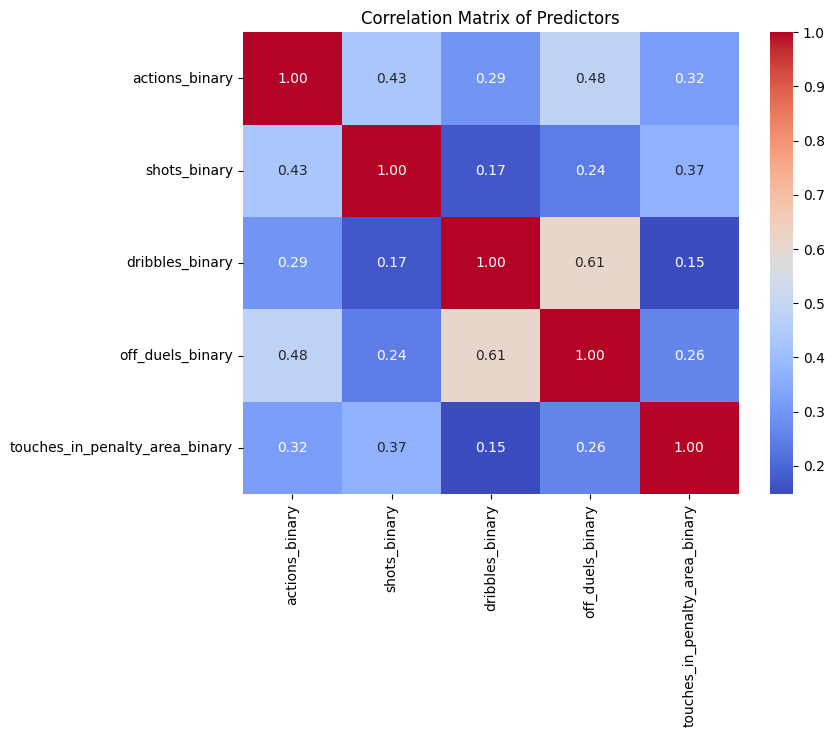

In [8]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Predictors')
plt.show()
# examining correlation between coefficients


In [9]:
Y = YX[:,0]
X = pd.DataFrame(YX[:,1:], columns=['actions_binary', 'shots_binary', 'dribbles_binary', 'off_duels_binary', 'touches_in_penalty_area_binary'])
print(Y.shape, X.shape)


(248,) (248, 5)


In [10]:
X_with_intercept = sm.add_constant(X)

model = sm.Logit(Y, X_with_intercept).fit()

Optimization terminated successfully.
         Current function value: 0.462961
         Iterations 6


In [11]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  248
Model:                          Logit   Df Residuals:                      242
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.3289
Time:                        08:00:38   Log-Likelihood:                -114.81
converged:                       True   LL-Null:                       -171.09
Covariance Type:            nonrobust   LLR p-value:                 1.180e-22
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.7654      0.280     -6.304      0.000      -2.314      -1.217
actions_binary                     0.0585      0.394      0.149      0.

In [12]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

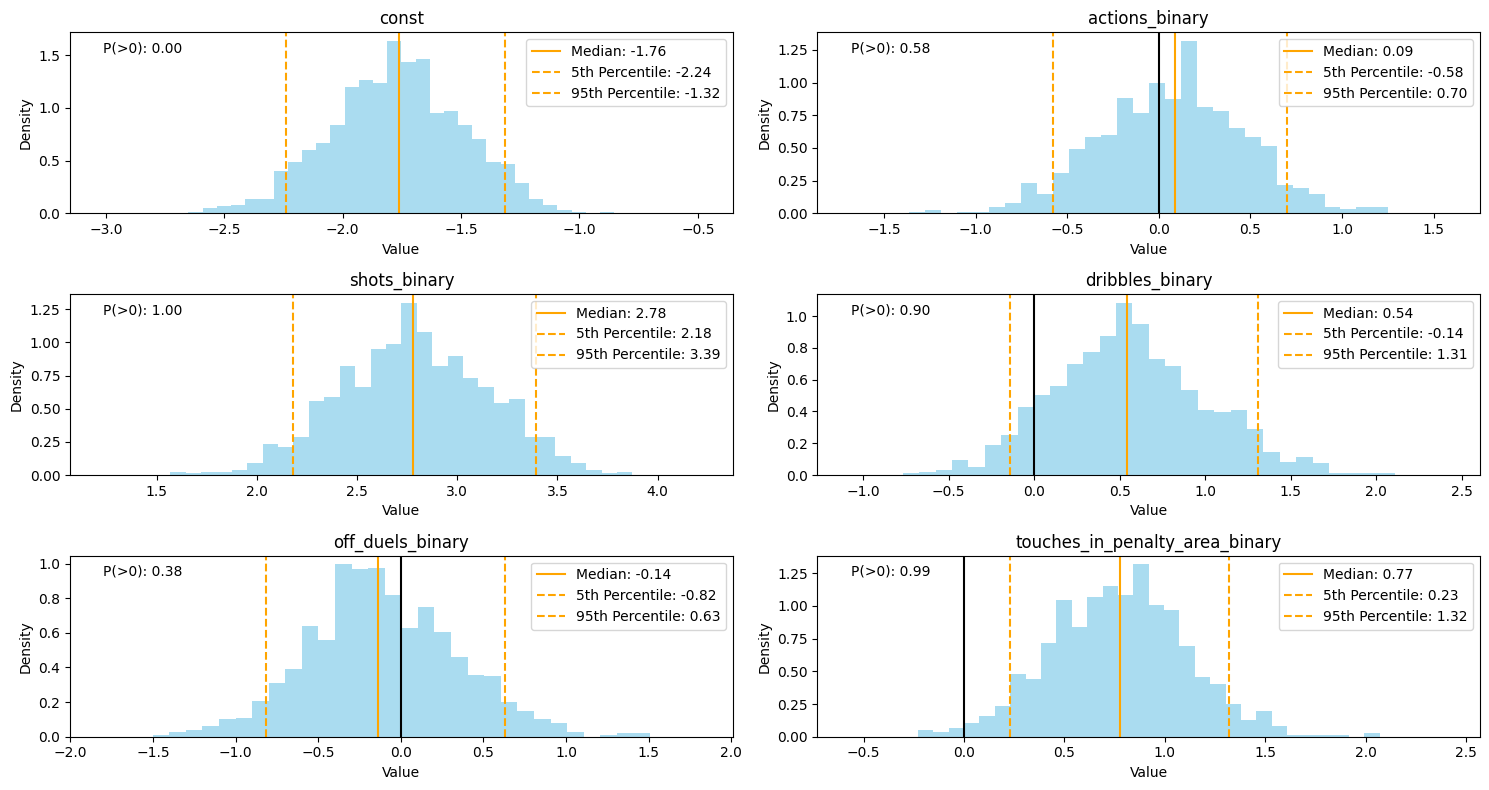

In [13]:
coeffs = model.params.values
num_coeffs = len(coeffs)
# Calculate statistics for each coefficient
medians = np.median(simulated_betas, axis=0)
lower_quantiles = np.percentile(simulated_betas, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas, 95, axis=0)
prob_positive = np.mean(simulated_betas > 0, axis=0)

# Plot histograms of each coefficient
num_rows = (num_coeffs + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(num_coeffs):
    ax = axs[i]
    ax.hist(simulated_betas[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_with_intercept.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim(left=min(simulated_betas[:, i]) - 0.5, right=max(simulated_betas[:, i]) + 0.5)
    
# Hide empty subplot
if num_coeffs % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [14]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(np.dot(simulated_betas, average_X))


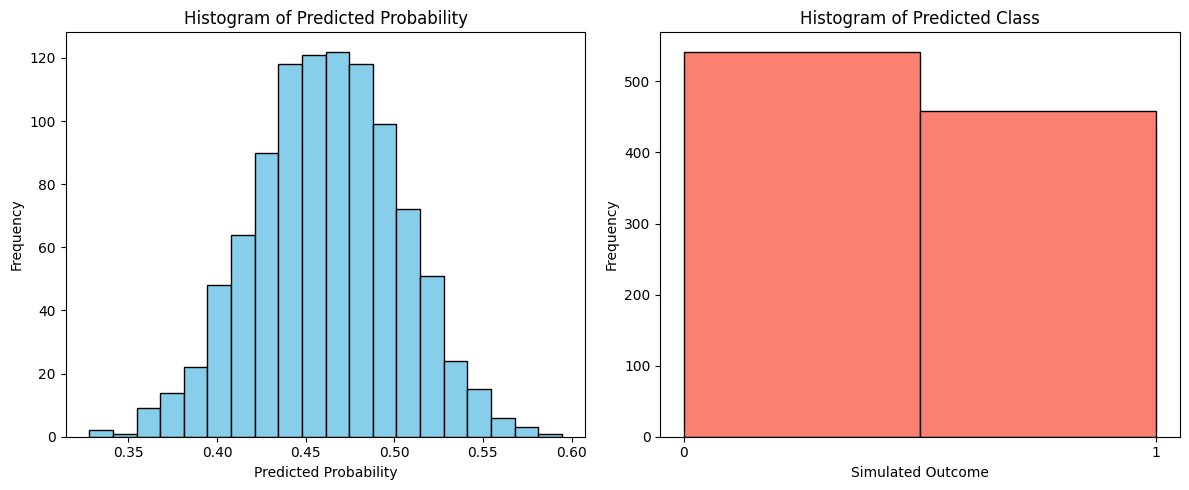

[0.48272676 0.51924624 0.44462051 0.4311509  0.44458384 0.46037006
 0.47094107 0.45688986 0.39662279 0.46923282 0.42805539 0.46141553
 0.467563   0.43160992 0.40874414 0.51314929 0.45406983 0.47372902
 0.51214253 0.4696953  0.46610975 0.48454989 0.42564305 0.44142658
 0.50163036 0.46602007 0.48491055 0.44775259 0.4702108  0.46122081
 0.49537638 0.43860806 0.46984438 0.50037172 0.46449938 0.47024952
 0.46705843 0.47091096 0.42504671 0.48352183 0.50860084 0.36921483
 0.49010164 0.46174856 0.47177031 0.38194132 0.41652071 0.48354095
 0.44023617 0.45199483 0.48818579 0.49808901 0.51932741 0.51813642
 0.49479667 0.51662602 0.47757215 0.43673524 0.50293557 0.3579654
 0.41798854 0.43257678 0.44984355 0.51721485 0.45654544 0.41838046
 0.5213136  0.42917946 0.39261805 0.46899151 0.39201364 0.45440268
 0.39190383 0.48573711 0.42811316 0.48883381 0.4167326  0.49524018
 0.43095894 0.54703533 0.4146511  0.37211796 0.51937692 0.46293313
 0.53826887 0.53517013 0.45026793 0.40792566 0.45735468 0.45694

In [15]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = np.random.binomial(1, new_predicted_probs)

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
print(new_predicted_probs)
print(new_simulated_outcomes)